In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix,f1_score
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay

In [2]:
data = pd.read_csv("Data/fraud_data.csv")
data = data.drop('Unnamed: 0',axis=1)
print("Shape is" , data.shape)
data.head()

Shape is (180519, 14)


,Type,Delivery Status,Late_delivery_risk,Category Name,Customer City,Customer Segment,Department Name,Market,Order Country,Order Item Quantity,Order Region,Product Price,Shipping Mode,FraudOrder
0,DEBIT,Advance shipping,0,Sporting Goods,Caguas,Consumer,Fitness,Pacific Asia,Indonesia,1,Southeast Asia,327.75,Standard Class,False
1,TRANSFER,Late delivery,1,Sporting Goods,Caguas,Consumer,Fitness,Pacific Asia,India,1,South Asia,327.75,Standard Class,False
2,CASH,Shipping on time,0,Sporting Goods,San Jose,Consumer,Fitness,Pacific Asia,India,1,South Asia,327.75,Standard Class,False
3,DEBIT,Advance shipping,0,Sporting Goods,Los Angeles,Home Office,Fitness,Pacific Asia,Australia,1,Oceania,327.75,Standard Class,False
4,PAYMENT,Advance shipping,0,Sporting Goods,Caguas,Corporate,Fitness,Pacific Asia,Australia,1,Oceania,327.75,Standard Class,False


In [3]:
# data = data.sample(50000)
# data.shape

In [4]:
for col in data.columns:
    if data[col].nunique() > 10:
        print(col,":",data[col].nunique())

Category Name : 50
Customer City : 563
Department Name : 11
Order Country : 164
Order Region : 23
Product Price : 75


In [5]:
CategoryEncoder,CityEncoder,DepartmentEncoder,countryEncoder,RegionEncoder =  LabelEncoder(),LabelEncoder(),LabelEncoder(),LabelEncoder(),LabelEncoder()

In [6]:
data['Category Name'] = CategoryEncoder.fit_transform(data['Category Name'])
data['Customer City'] = CityEncoder.fit_transform(data['Customer City'])
data['Department Name'] = DepartmentEncoder.fit_transform(data['Department Name'])
data['Order Country'] = countryEncoder.fit_transform(data['Order Country'])
data['Order Region'] = RegionEncoder.fit_transform(data['Order Region'])

In [7]:
data['FraudOrder'] = data['FraudOrder'].apply(lambda x: -1 if x == True else 1)

In [8]:
data.head()

,Type,Delivery Status,Late_delivery_risk,Category Name,Customer City,Customer Segment,Department Name,Market,Order Country,Order Item Quantity,Order Region,Product Price,Shipping Mode,FraudOrder
0,DEBIT,Advance shipping,0,40,66,Consumer,4,Pacific Asia,70,1,15,327.75,Standard Class,1
1,TRANSFER,Late delivery,1,40,66,Consumer,4,Pacific Asia,69,1,13,327.75,Standard Class,1
2,CASH,Shipping on time,0,40,452,Consumer,4,Pacific Asia,69,1,13,327.75,Standard Class,1
3,DEBIT,Advance shipping,0,40,285,Home Office,4,Pacific Asia,8,1,11,327.75,Standard Class,1
4,PAYMENT,Advance shipping,0,40,66,Corporate,4,Pacific Asia,8,1,11,327.75,Standard Class,1


In [9]:
data = pd.get_dummies(data)
data.head()

,Late_delivery_risk,Category Name,Customer City,Department Name,Order Country,Order Item Quantity,Order Region,Product Price,FraudOrder,Type_CASH,...,Customer Segment_Home Office,Market_Africa,Market_Europe,Market_LATAM,Market_Pacific Asia,Market_USCA,Shipping Mode_First Class,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class
0,0,40,66,4,70,1,15,327.75,1,0,...,0,0,0,0,1,0,0,0,0,1
1,1,40,66,4,69,1,13,327.75,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,40,452,4,69,1,13,327.75,1,1,...,0,0,0,0,1,0,0,0,0,1
3,0,40,285,4,8,1,11,327.75,1,0,...,1,0,0,0,1,0,0,0,0,1
4,0,40,66,4,8,1,11,327.75,1,0,...,0,0,0,0,1,0,0,0,0,1


In [10]:
normal_data = data[data['FraudOrder'] == 1]
anomalous_data = data[data['FraudOrder'] == -1]

In [11]:
normal_train , normal_test = train_test_split(normal_data,test_size= .05,random_state=42)
normal_train.shape , normal_test.shape

((167634, 29), (8823, 29))

In [12]:
test_data = pd.concat([normal_test,anomalous_data],axis=0)
test_data.head()

,Late_delivery_risk,Category Name,Customer City,Department Name,Order Country,Order Item Quantity,Order Region,Product Price,FraudOrder,Type_CASH,...,Customer Segment_Home Office,Market_Africa,Market_Europe,Market_LATAM,Market_Pacific Asia,Market_USCA,Shipping Mode_First Class,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class
78893,1,46,411,3,48,1,18,199.990005,1,0,...,0,0,0,0,0,1,0,0,0,1
166083,1,34,314,0,108,1,11,129.990005,1,0,...,1,0,0,0,1,0,0,0,1,0
60499,0,9,447,3,102,1,3,299.980011,1,0,...,0,0,0,1,0,0,0,0,0,1
69812,0,10,266,5,48,4,18,99.989998,1,0,...,0,0,0,0,0,1,0,0,0,1
124127,1,15,66,0,31,1,7,461.480011,1,0,...,0,0,0,0,1,0,0,0,0,1


In [13]:
x_normal_train = normal_train.drop('FraudOrder',axis=1)

In [14]:
x_test = test_data.drop('FraudOrder',axis=1)
y_test = test_data['FraudOrder']
list(y_test).count(1) , list(y_test).count(-1)

(8823, 4062)

In [15]:
scaler = StandardScaler()

In [16]:
x_normal_train = scaler.fit_transform(x_normal_train)

In [17]:
x_test = scaler.transform(x_test)

In [18]:
models = {"SVM":OneClassSVM(kernel='rbf', nu=0.05),
         "IsolationForest":IsolationForest(n_estimators=500, max_samples='auto', contamination=float(0.1), random_state=42)}

In [19]:
# for name,my_model in models.items():
#     print("\n",name)
#     my_model.fit(x_normal_train)
#     y_pred = model.predict(x_test)
#     print("\nAccuracy ", accuracy_score(y_pred,y_test))
#     print("\nPrecision", precision_score(y_pred,y_test))
#     print("\nRecall", recall_score(y_pred,y_test))
#     print("\nF1 Score", f1_score(y_pred,y_test))
#     print("\nClassification Report",classification_report(y_pred,y_test))

In [161]:
model = OneClassSVM(kernel='rbf', nu=0.05)
model.fit(x_normal_train)
y_pred = model.predict(x_test)
print("\nAccuracy ", accuracy_score(y_pred,y_test))
print("\nPrecision", precision_score(y_pred,y_test))
print("\nRecall", recall_score(y_pred,y_test))
print("\nF1 Score", f1_score(y_pred,y_test))
print("\nClassification Report",classification_report(y_pred,y_test))

In [20]:
model = IsolationForest(n_estimators=500, max_samples='auto', contamination=float(0.1), random_state=42)
model.fit(x_normal_train)
y_pred = model.predict(x_test)
print("\nAccuracy ", accuracy_score(y_pred,y_test))
print("\nPrecision", precision_score(y_pred,y_test))
print("\nRecall", recall_score(y_pred,y_test))
print("\nF1 Score", f1_score(y_pred,y_test))
print("\nClassification Report",classification_report(y_pred,y_test))


Accuracy  0.826930539386884

Precision 0.8994673013714156

Recall 0.8552645759241297

F1 Score 0.876809192354436

Classification Report               precision    recall  f1-score   support

          -1       0.67      0.75      0.71      3606
           1       0.90      0.86      0.88      9279

    accuracy                           0.83     12885
   macro avg       0.78      0.80      0.79     12885
weighted avg       0.84      0.83      0.83     12885



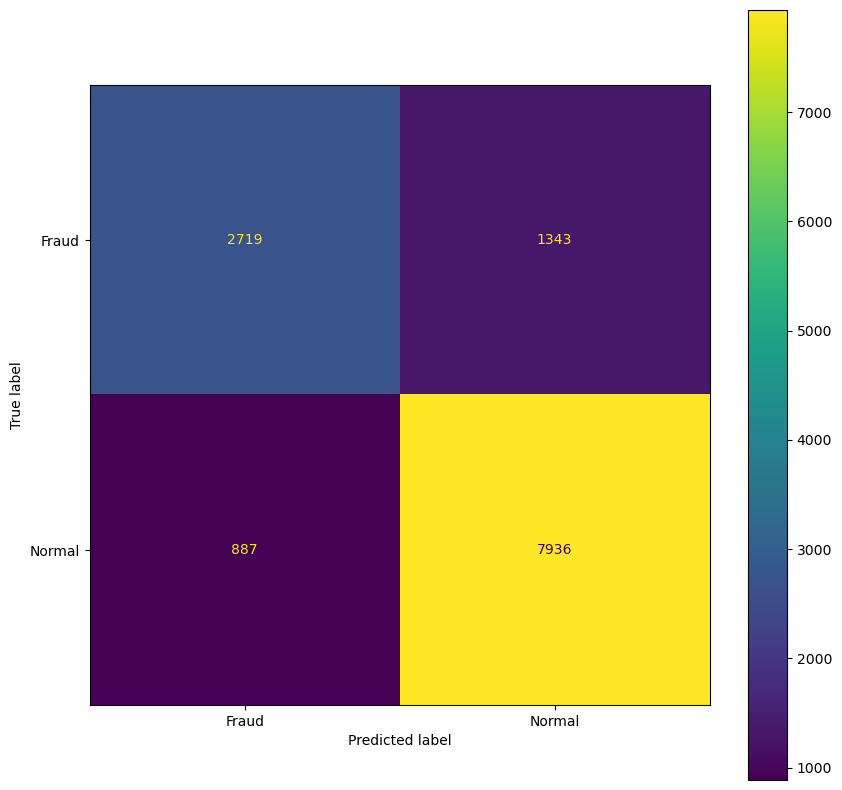

In [24]:
fig,ax = plt.subplots(figsize=(10,10))
confusion = confusion_matrix(y_test, y_pred)
display_con = ConfusionMatrixDisplay(confusion,display_labels=['Fraud',"Normal"])
display_con.plot(ax=ax)
plt.show()